<style>
{
  margin: 0;
  padding: 0;
  box-sizing: border-box;}
 
  body {
  margin-left: -24px;
  margin-top: 0;
  font-family: "Arial", sans-serif;
  width: 100%;
  height: 100vh;
  display: flex;
  flex-direction: column;
  justify-content: space-between;
  box-sizing: border-box;
}
  .title {
    text-align: center;
    font-size: 36px; 
    font-weight: bold;
    align-items: center;
    margin-top: 50px; 
  }
  .subtitle {
    text-align: center;
    font-size: 28px; 
    font-weight: bold;
    align-items: center;
    margin-bottom: 30px;
  }
  .logo {
    text-align: center;
    margin: 50px 0; 
    align-items: center;
  }
  .project-title {
    text-align: center;
    font-size: 28px; 
    font-weight: bold;
    align-items: center;
    margin: 40px 0; 
  }
  .authors {
    font-size: 20px; 
    text-align: center;
    margin-bottom: 50px;
    align-items: center;
  }
</style>
 
<div class="title">POLITECHNIKA LUBELSKA</div>
<div class="subtitle">WYDZIAŁ MATEMATYKI I INFORMATYKI TECHNICZNEJ</div>
<div class="subtitle">Kierunek: Inżynieria i Analiza Danych</div>
 
<div class="logo">
<img src="logopl.png" alt="Logo Politechniki Lubelskiej" width="300"> <!-- Większe logo -->
</div>
 
<div class="project-title">Projekt Zaliczeniowy <br> Eksploracja danych</div>
<div class="subtitle"><em>Praca wykonana przez:</em></div>
<div class="authors">
<strong>Szymon Sergiel, Nr albumu: 101010</strong> <br>
<strong>Jakub Kalita, Nr albumu: 100976</strong> <br>

</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.base import clone
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import mutual_info_classif
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, make_scorer
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight

In [2]:
df = pd.read_csv('hcvdat0.csv', sep = ',')
df.rename(columns = {'Unnamed: 0': 'ID'}, inplace = True)
df.drop(columns = ['ID'], inplace = True)
df.head()

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


## Zdefiniowanie problemu predykcyjnego oraz scharakteryzowanie analizowanego zbioru danych

### Cel analizy

Celem projektu jest zbudowanie modelu predykcyjnego, który na podstawie danych demograficznych oraz wyników badań laboratoryjnych będzie klasyfikował stan zdrowia pacjentów w kontekście chorób wątroby. Kluczowym zadaniem jest przypisanie pacjenta do jednej z pięciu klas:

**0: Blood Donor (osoba zdrowa, oddająca krew)**

**1: Suspect Blood Donor (podejrzenie nieprawidłowości u dawcy)**

**2: Hepatitis (wirusowe zapalenie wątroby)**

**3: Fibrosis (włóknienie wątroby)**

**4: Cirrhosis (marskość wątroby)**

Problem ma charakter wieloklasowej klasyfikacji.

### Charakterystyka zbioru danych

Zbiór danych składa się z następujących zmiennych:

**Category - Klasa docelowa (stan zdrowia pacjenta)**

**Age - Wiek pacjenta**

**Sex - Płeć pacjenta**

**ALB - Poziom albuminy**

**ALP - Poziom fosfatazy alkalicznej**

**ALT - Poziom aminotransferazy alaninowej**

**AST - Poziom aminotransferazy asparaginianowej**

**BIL - Poziom bilirubiny**

**CHE - Poziom cholinesterazy**

**CHOL - Poziom cholesterolu**

**CREA - Poziom kreatyniny**

**GGT - Poziom gamma-glutamylotransferazy**

**PROT - Poziom białka całkowitego**

Niektóre zmienne są tekstowe (Category, Sex), większość zmiennych jest numerycznych (ciągłych).

### Znaczenie problemu

Prawidłowa klasyfikacja stanu zdrowia pacjenta na podstawie badań laboratoryjnych może stanowić istotne wsparcie dla lekarzy w procesie diagnostycznym, umożliwiając wczesne wykrycie poważnych chorób wątroby i wdrożenie odpowiedniego leczenia.

## Czyszczenie danych

### Zamiana etykiet w zmiennej Category na wartości liczbowe

In [3]:
df['Category'] = df['Category'].str.extract(r'^(\d+s?|\d+)')

In [4]:
label_map = {
    '0': 0,
    '0s': 1,
    '1': 2,
    '2': 3,
    '3': 4
}

df['Category'] = df['Category'].map(label_map)

### Zamiana płci na wartości binarne

In [5]:
df['Sex'] = df['Sex'].map({'m': 1, 'f': 0})

In [6]:
df.dtypes

Category      int64
Age           int64
Sex           int64
ALB         float64
ALP         float64
ALT         float64
AST         float64
BIL         float64
CHE         float64
CHOL        float64
CREA        float64
GGT         float64
PROT        float64
dtype: object

Zakodowano zmienną celu Category oraz zmienną Sex na format numeryczny (m = 1, f = 0), aby dostosować dane do algorytmów uczenia maszynowego.

### Usuwanie braków danych

In [7]:
df.shape

(615, 13)

In [8]:
df.groupby('Category', observed = True)['Category'].count()

Category
0    533
1      7
2     24
3     21
4     30
Name: Category, dtype: int64

In [9]:
Missing_values_percent = 100*(df.isnull().sum()/len(df['Category']))
print(Missing_values_percent)

Category    0.000000
Age         0.000000
Sex         0.000000
ALB         0.162602
ALP         2.926829
ALT         0.162602
AST         0.000000
BIL         0.000000
CHE         0.000000
CHOL        1.626016
CREA        0.000000
GGT         0.000000
PROT        0.162602
dtype: float64


In [10]:
df_drop = df.dropna()

In [11]:
df_drop.groupby('Category', observed = True)['Category'].count()

Category
0    526
1      7
2     20
3     12
4     24
Name: Category, dtype: int64

Usunięcie braków danych spowodowało znaczny spadek liczby obserwacji dla mało liczebnych klas 2, 3 oraz 4. Z tego powodu na naszym zbiorze należy wykonać imputację (ten krok należy poprzedzić podziałem zbioru na zbiór treningowy, testowy i walidacyjny).

In [12]:
df = df.reset_index(drop=True)

X = df.drop(columns = ['Category'])
y = df['Category']

X_train, X_not_train, y_train, y_not_train = train_test_split(X, y, test_size = 0.3, random_state = 19, stratify = y)
X_test, X_val, y_test, y_val = train_test_split(X_not_train, y_not_train, test_size = 0.5, random_state = 19, stratify = y_not_train)

In [13]:
X_train.shape, X_test.shape, X_val.shape

((430, 12), (92, 12), (93, 12))

Nastąpił podział na zbiory:
- Treningowy: 430 obserwacji
- Testowy: 92 obserwacje
- Walidacyjny: 93 obserwacje

In [14]:
num_cols = X_train.select_dtypes(include = 'number').columns
cat_cols = X_train.select_dtypes(exclude = 'number').columns

numeric_pipe = Pipeline([
    ('impute', KNNImputer(n_neighbors = 5,
                          weights = 'distance',
                          metric = 'nan_euclidean'))
])

preprocess = ColumnTransformer([
    ('num', numeric_pipe, num_cols),
    ('cat', 'passthrough', cat_cols)
], remainder = 'drop', verbose_feature_names_out = False)

X_train_clean = pd.DataFrame(
    preprocess.fit_transform(X_train),
    index = X_train.index,
    columns = preprocess.get_feature_names_out()
)

X_test_clean = pd.DataFrame(
    preprocess.transform(X_test),
    index = X_test.index,
    columns = preprocess.get_feature_names_out()
)

X_val_clean = pd.DataFrame(
    preprocess.transform(X_val),
    index = X_val.index,
    columns = preprocess.get_feature_names_out()
)

In [15]:
Missing_values_percent = 100*(X_train_clean.isnull().sum()/len(df["Category"]))
print(Missing_values_percent)

Age     0.0
Sex     0.0
ALB     0.0
ALP     0.0
ALT     0.0
AST     0.0
BIL     0.0
CHE     0.0
CHOL    0.0
CREA    0.0
GGT     0.0
PROT    0.0
dtype: float64


W celu uzupełnienia brakujących wartości w zbiorze danych zastosowano metodę imputacji przy użyciu algorytmu K-Nearest Neighbors (KNNImputer). Metoda ta polega na szacowaniu brakujących wartości na podstawie wartości obserwacji najbardziej podobnych (najbliższych) w przestrzeni cech. Wykorzystanie KNN pozwala na uwzględnienie wielowymiarowej struktury danych oraz relacji pomiędzy poszczególnymi zmiennymi.

In [16]:
df['Category'] = df['Category'].astype('int')
df['Sex'] = df['Sex'].astype('int')
df['Age'] = df['Age'].astype('int')

df['Category'] = df['Category'].astype('category')
df['Sex'] = df['Sex'].astype('category')

In [17]:
df.dtypes

Category    category
Age            int64
Sex         category
ALB          float64
ALP          float64
ALT          float64
AST          float64
BIL          float64
CHE          float64
CHOL         float64
CREA         float64
GGT          float64
PROT         float64
dtype: object

W trakcie procesu imputacji przy użyciu algorytmu K-Nearest Neighbors wszystkie zmienne numeryczne zostały automatycznie przekształcone na typ zmiennoprzecinkowy (float), co wynika ze specyfiki działania algorytmu opartego na wyliczaniu odległości między obserwacjami. Po przeprowadzonej imputacji zmieniliśmy typy tych zmiennych, gdzie nastąpiło to przekształcenie (Age na zmienną numeryczną, Category i Sex na zmienną numeryczną kategoryczną).

## Wstępna selekcja cech

In [18]:
mi = mutual_info_classif(X_train_clean, y_train, discrete_features = 'auto',random_state=19)
mi = pd.Series(mi, index = X_train_clean.columns).sort_values(ascending = False)
mi

AST     0.216129
CHE     0.118712
BIL     0.109705
GGT     0.106853
PROT    0.098082
ALB     0.095360
ALT     0.089941
CHOL    0.088092
CREA    0.079314
ALP     0.075951
Sex     0.042790
Age     0.015736
dtype: float64

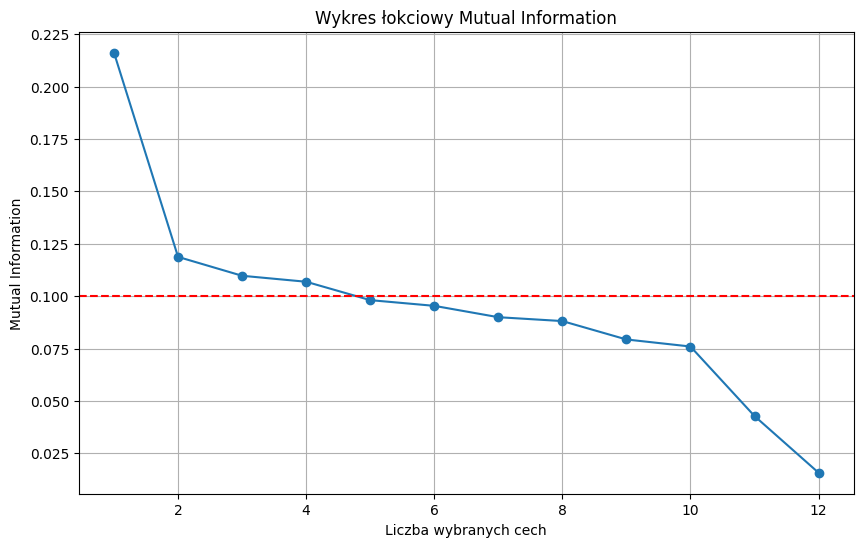

In [19]:
plt.figure(figsize = (10,6))
plt.plot(range(1, len(mi) + 1), mi, marker = 'o')
plt.axhline(y = 0.1, color = 'r', linestyle = 'dashed')
plt.xlabel('Liczba wybranych cech')
plt.ylabel('Mutual Information')
plt.title('Wykres łokciowy Mutual Information')
plt.grid(True)

Na podstawie metryki Mutual Information oraz wykresu łokciowego do dalszej analizy wybieramy 4 zmienne przekraczające ustalony próg MI równy 0.1 - AST, CHE, GGT  oraz BIL .

In [20]:
X_train = X_train_clean.drop(columns = ['CHOL','PROT', 'Age', 'Sex', 'ALB', 'ALP', 'ALT', 'CREA'])
X_test = X_test_clean.drop(columns = ['CHOL','PROT', 'Age', 'Sex', 'ALB', 'ALP', 'ALT', 'CREA'])
X_val = X_val_clean.drop(columns = ['CHOL','PROT',  'Age', 'Sex', 'ALB', 'ALP', 'ALT', 'CREA'])

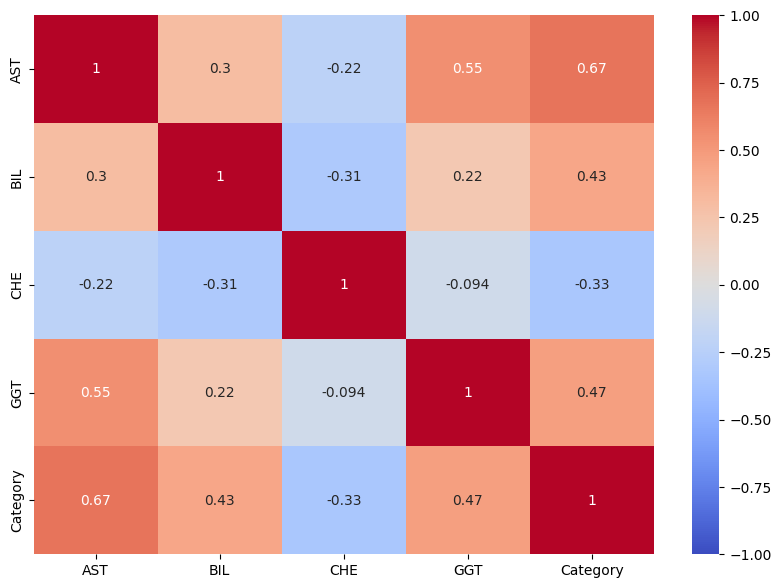

In [21]:
appended = pd.concat([X_train, y_train], axis = 1)

plt.figure(figsize = (10, 7))
sns.heatmap(appended.corr(), annot = True, vmin = -1, cmap = "coolwarm")
plt.show()

Na podstawie heatmapy korelacji nie usuwamy żadnej ze zmiennych.

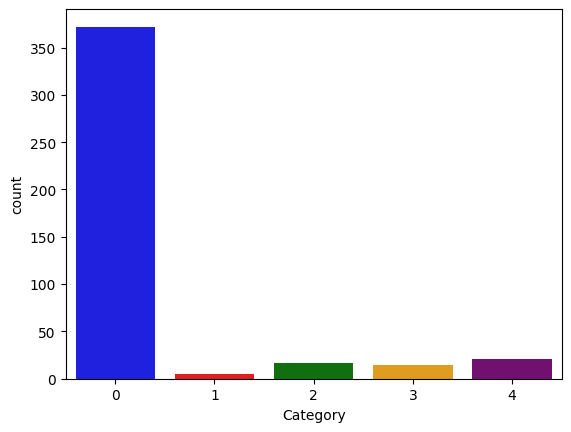

In [22]:
colors = ['blue', 'red', 'green', 'orange', 'purple']

sns.countplot(x = 'Category', data = appended, palette = colors, hue = 'Category', legend = False)
plt.show()

Nasze dane są bardzo niezbalansowane, dlatego w dalszej części projektu zajmiemy się m.in. balansowaniem klas metodami oversamplingu. W naszym przypadku undersampling byłby nierozsądny, gdyż nie chcemy jeszcze bardziej zmniejszać ilości danych, na których możemy pracować.

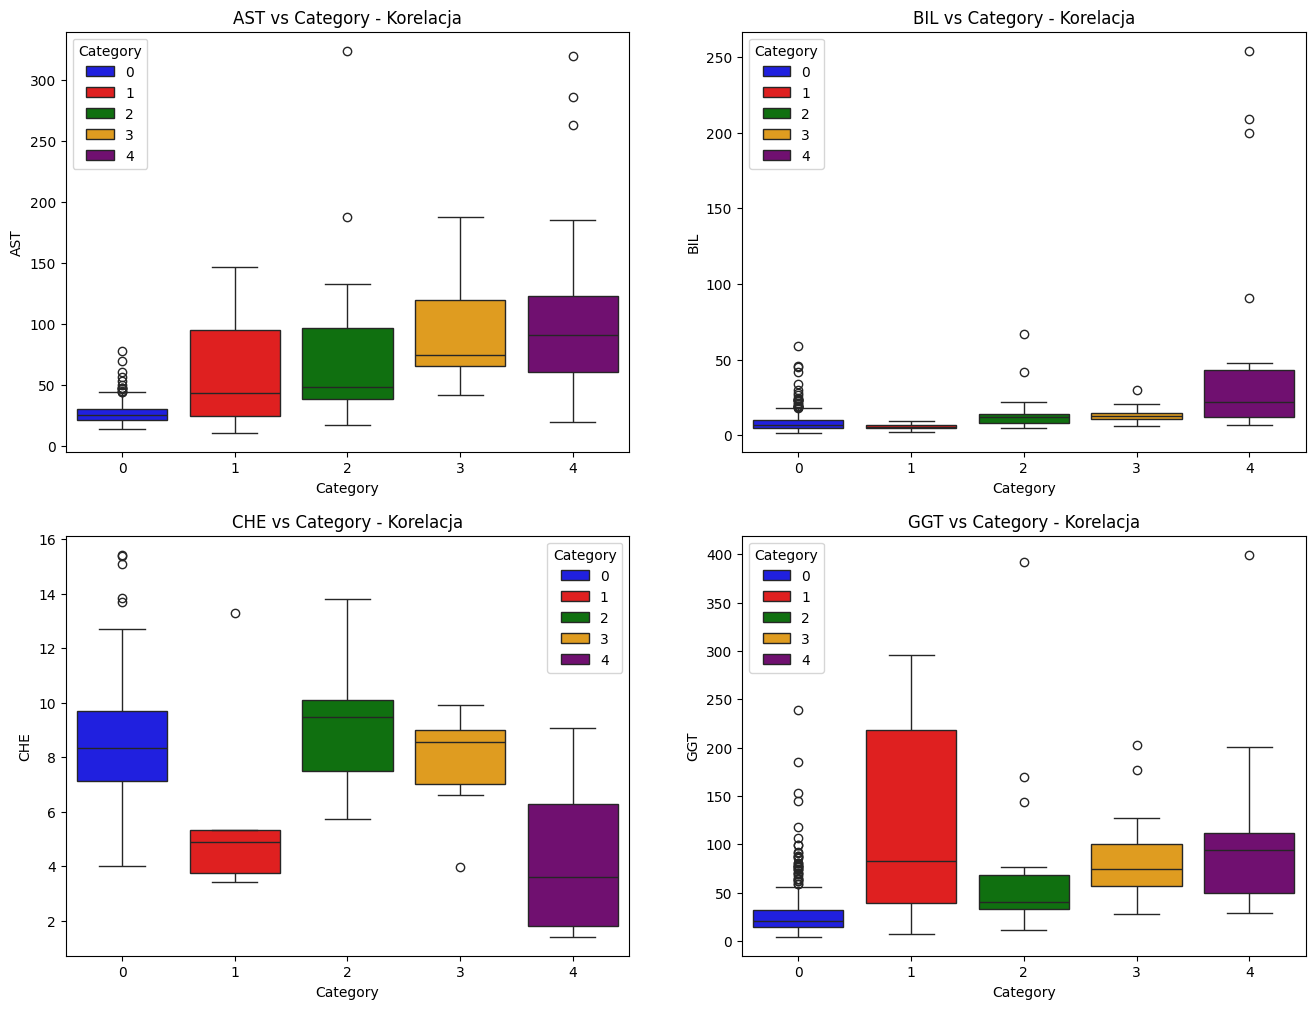

In [23]:
f, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (16, 12))

sns.boxplot(x = 'Category', y = 'AST', data = appended, palette = colors, hue = 'Category', ax = axes[0, 0])
axes[0, 0].set_title('AST vs Category - Korelacja')

sns.boxplot(x = 'Category', y = 'BIL', data = appended, palette = colors, hue = 'Category', ax = axes[0, 1])
axes[0, 1].set_title('BIL vs Category - Korelacja')

sns.boxplot(x = 'Category', y = 'CHE', data = appended, palette = colors, hue = 'Category', ax = axes[1, 0])
axes[1, 0].set_title('CHE vs Category - Korelacja')

sns.boxplot(x = 'Category', y = 'GGT', data = appended, palette = colors, hue = 'Category', ax = axes[1, 1])
axes[1, 1].set_title('GGT vs Category - Korelacja')

plt.show()

##### **AST (Aminotransferaza asparaginianowa) vs Category**
- Wzrost poziomu AST wraz z pogarszaniem się stanu wątroby.
- Najwyższe wartości w kategorii marskości (4), co jest zgodne z uszkodzeniem komórek wątrobowych.

##### **BIL (Bilirubina) vs Category**
- Wzrost bilirubiny koreluje z zaawansowaniem choroby.
- Najwyższe poziomy występują przy marskości (4), co odzwierciedla zaburzenia metabolizmu bilirubiny.

##### **CHE (Cholinesteraza) vs Category**
- Najwyższe poziomy u zdrowych dawców (0), podobne u pacjentów z WZW C.
- Niskie wartości u dawców z podejrzeniem nieprawidłowości (1), co może wskazywać na pewne niezidentyfikowane problemy.
- Znaczący spadek przy marskości (4), co wskazuje na spadek zdolności syntetycznej wątroby.

##### **GGT (Gamma-glutamylotransferaza) vs Category**
- Wysokie wartości dla grupy dawców z podejrzeniem nieprawidłowości (1), co może wskazywać na pewne niezidentyfikowane problemy.
- Wartości GGT rosną w grupach chorych (szczególnie kategorie 2, 3, 4).
- Najwyższe poziomy przy marskości – zgodne z cholestazą i uszkodzeniem komórek dróg żółciowych.

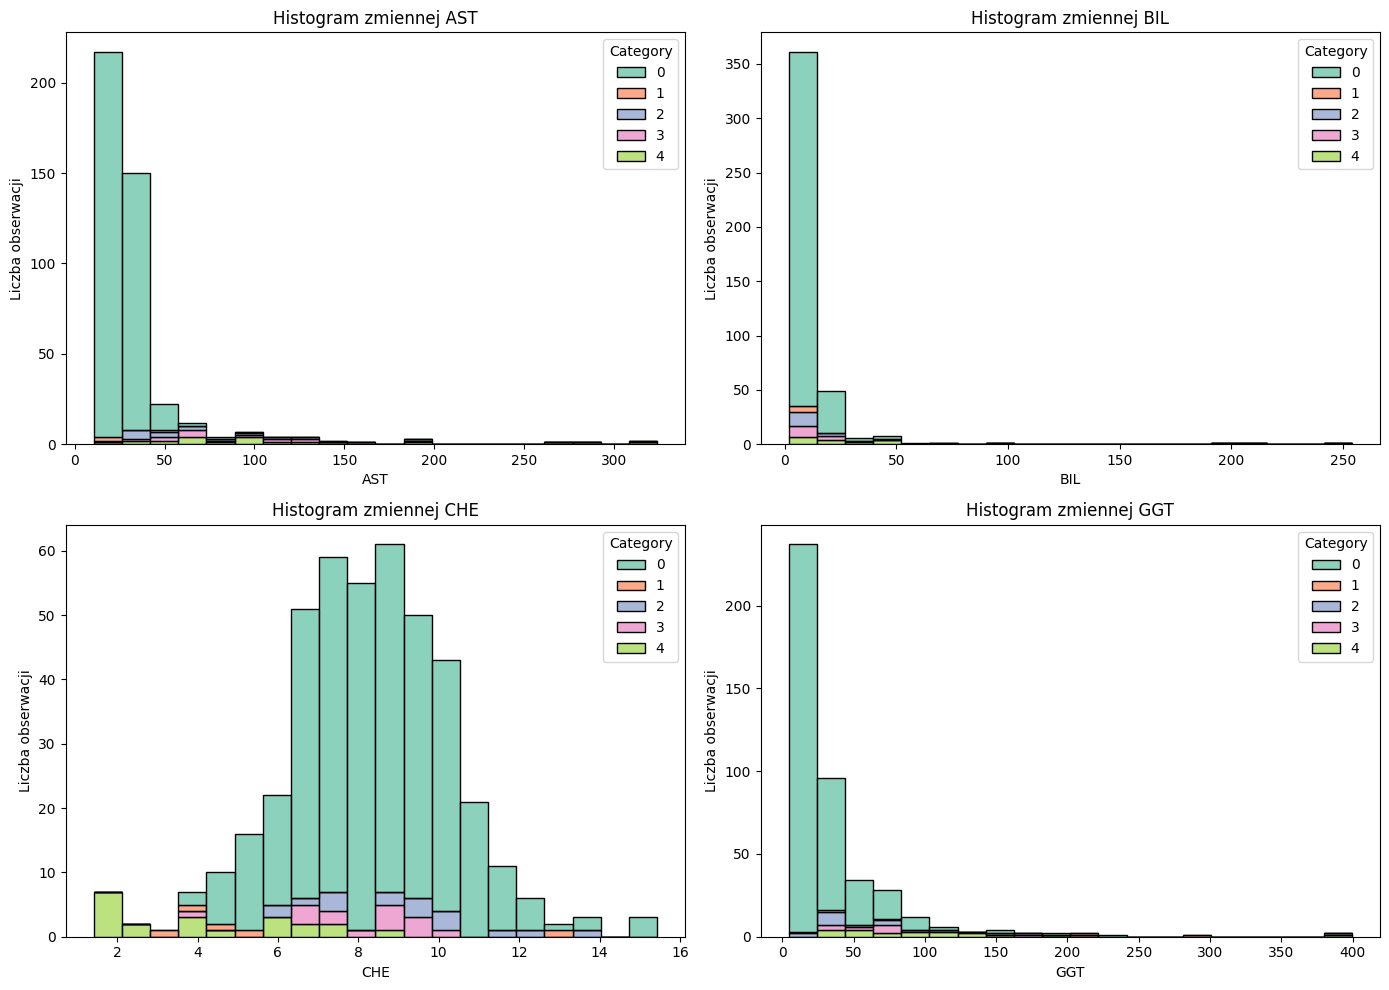

In [24]:
variables = ['AST', 'BIL', 'CHE', 'GGT']

# Tworzymy subplots 2x2
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

# Iterujemy po zmiennych i osiach
for i, var in enumerate(variables):
    sns.histplot(data=appended, x=var, hue='Category', multiple='stack', palette='Set2', bins=20, ax=axs[i])
    axs[i].set_title(f'Histogram zmiennej {var}')
    axs[i].set_xlabel(var)
    axs[i].set_ylabel('Liczba obserwacji')

plt.tight_layout()
plt.show()

#### **HIstogram zmiennej AST**

- Większość obserwacji skupia się przy bardzo niskich wartościach (0-50).

- Klasa zdrowych dawców (0) dominuje przy niskich wartościach.

- Występują nieliczne przypadki z podwyższonym AST (powyżej 50), które częściej należą do pacjentów z problemami wątrobowymi (klasy 1-4).

#### **Histogram zmiennej BIL**

- Podobny schemat jak dla AST: większość wartości jest niska (0-20).

- Klasa 0 (Blood Donor) koncentruje się przy bardzo niskich wartościach.

- Podwyższone wartości (20-50 i więcej) pojawiają się głównie u pacjentów z chorobami wątroby.

#### **Histogram zmiennej CHE**
- Rozkład jest bardziej symetryczny w porównaniu do AST i BIL.

- Najwięcej obserwacji dla klasy 0 występuje w przedziale 7-10.

- Niższe wartości CHE (poniżej 6) częściej obserwowane są u chorych pacjentów (klasy 1-4), co może wskazywać na związek z uszkodzeniem wątroby.

#### **Histogram zmiennej GGT**

- Silnie skośny rozkład: najwięcej wartości w przedziale 0-50.

- Klasa 0 dominuje przy niskich wartościach GGT.

- Wyższe wartości (powyżej 100) częściej należą do pacjentów z problemami wątrobowymi — klasy 1-4 są tu wyraźniej reprezentowane.

## Balansowanie klas w zbiorze treningowym

In [25]:
samplers = {
    "random_oversampling": RandomOverSampler(random_state=19),
    "smote": SMOTE(random_state=19, k_neighbors=4),
    "adasyn": ADASYN(random_state=19, n_neighbors=4)
}

X_train_smote, y_train_smote = samplers["smote"].fit_resample(X_train, y_train)
X_train_adasyn, y_train_adasyn = samplers["adasyn"].fit_resample(X_train, y_train)
X_train_over, y_train_over = samplers["random_oversampling"].fit_resample(X_train, y_train)

print("Oryginalny zbiór (bez resamplingu):", y_train.value_counts().to_dict())
print("SMOTE:", y_train_smote.value_counts().to_dict())
print("ADASYN:", y_train_adasyn.value_counts().to_dict())
print("Random Oversampling:", y_train_over.value_counts().to_dict())

Oryginalny zbiór (bez resamplingu): {0: 372, 4: 21, 2: 17, 3: 15, 1: 5}
SMOTE: {0: 372, 2: 372, 1: 372, 3: 372, 4: 372}
ADASYN: {2: 378, 4: 378, 0: 372, 1: 370, 3: 367}
Random Oversampling: {0: 372, 2: 372, 1: 372, 3: 372, 4: 372}


W celu zniwelowania problemu niezbalansowanych klas w danych treningowych, zastosowano trzy popularne techniki oversamplingu: RandomOverSampler, SMOTE oraz ADASYN. Każda z nich generuje nowe przykłady dla klas mniejszościowych, jednak różnią się podejściem do ich tworzenia.

RandomOverSampler - najprostsza metoda, która losowo powiela istniejące próbki z klas mniejszościowych, aż do osiągnięcia równej liczby próbek w każdej klasie. Nie wprowadza nowych informacji, ale skutecznie balansuje zbiór.

SMOTE (Synthetic Minority Over-sampling Technique) - generuje syntetyczne przykłady dla klas mniejszościowych poprzez interpolację między istniejącymi próbkami. Dzięki temu uzyskuje się bardziej zróżnicowany zbiór, co może poprawić zdolność generalizacji modeli.

ADASYN (Adaptive Synthetic Sampling) - podobnie jak SMOTE tworzy syntetyczne próbki, ale koncentruje się bardziej na trudno klasyfikowalnych przykładach, tj. tych, które znajdują się w pobliżu granicy decyzyjnej. Dzięki temu dostosowuje się do lokalnej struktury danych.

Po zastosowaniu każdej z tych metod sprawdzono rozkład liczebności klas, aby potwierdzić, że zbiór został poprawnie zbalansowany. Wszystkie techniki doprowadziły do wyrównania liczby próbek w każdej klasie, co pozwoli na trenowanie modeli w bardziej sprawiedliwych warunkach, bez faworyzowania klas dominujących.

## Porównanie modeli klasyfikacyjnych w zależności od metody balansowania danych

In [26]:
datasets = {
    "Oryginalny": (X_train, y_train),
    "SMOTE": (X_train_smote, y_train_smote),
    "ADASYN": (X_train_adasyn, y_train_adasyn),
    "Random Oversampling": (X_train_over, y_train_over),
}

In [27]:
def test_balancing_methods(model, model_name, datasets, X_val, y_val):
    results = {model_name: {}}

    for name, (X_tr, y_tr) in datasets.items():
        clf = clone(model)
        clf.fit(X_tr, y_tr)

        y_pred = clf.predict(X_val)
        cm = confusion_matrix(y_val, y_pred)

        results[model_name][name] = {
            "F1-Score_Val": f1_score(y_val, y_pred, average="weighted", zero_division=0),
            "Recall_Val": recall_score(y_val, y_pred, average="weighted", zero_division=0),
            "Precision_Val": precision_score(y_val, y_pred, average="weighted", zero_division=0),
            "Accuracy_Val": accuracy_score(y_val, y_pred),
            "Confusion_Matrix_Val": cm
        }

    return results

W celu oceny skuteczności różnych metod balansowania klas w kontekście predykcji, zdefiniowano funkcję test_balancing_methods. Funkcja ta porównuje jakość działania wybranego modelu uczenia maszynowego na zbiorach danych przygotowanych z użyciem różnych strategii resamplingu.

### Regresja logistyczna

In [28]:
model = LogisticRegression(
    random_state = 19,
    max_iter = 10000,
    penalty = 'l2',
    solver = 'lbfgs'
)
model_name = "Logistic Regression"

results_lr = test_balancing_methods(model, model_name, datasets, X_val, y_val)

In [29]:
df_results_lr = pd.DataFrame(results_lr["Logistic Regression"]).T
df_results_lr = df_results_lr.drop(columns=["Confusion_Matrix_Val"])
df_results_lr.style.apply(
    lambda row: [
        'background-color: #1f77d8; font-weight: bold' if row.name == 'Oryginalny' else ''
        for _ in row
    ], axis=1
).format(precision=3)

,F1-Score_Val,Recall_Val,Precision_Val,Accuracy_Val
Oryginalny,0.910,0.935,0.886,0.935
SMOTE,0.837,0.796,0.897,0.796
ADASYN,0.837,0.796,0.903,0.796
Random Oversampling,0.841,0.806,0.889,0.806


Model trenowany na oryginalnych danych:

- Osiąga najwyższy F1-Score (0.911) i najwyższy Recall (0.935) – oznacza to, że bardzo skutecznie rozpoznaje klasy i rzadko je pomija.

- Accuracy również najwyższe (0.935) – najlepszy ogólny wynik predykcji.

- Precision (0.889) jest tylko minimalnie niższy niż dla zbalansowanych wersji, ale pozostałe metryki są zdecydowanie lepsze.

Modele trenowane na danych po balansowaniu:

- Mają niższy F1-Score i Recall – oznacza to, że mimo wyższej precyzji (zwłaszcza w ADASYN), gorzej rozpoznają przypadki z mniejszych klas.

- Accuracy znacząco spada (do ok. 0.796–0.806), co świadczy o ogólnym pogorszeniu skuteczności.

Model Regresji Logistycznej trenowany na oryginalnym zbiorze danych zapewnia najlepszą równowagę między precyzją, czułością i ogólną skutecznością. W związku z tym został wybrany do dalszych analiz jako najbardziej efektywny.

### Random Forest

In [30]:
model = RandomForestClassifier(
    random_state = 19,
    n_estimators = 100,
    max_depth = 10
)
model_name = "Random Forest"

results_rf = test_balancing_methods(model, model_name, datasets, X_val, y_val)

In [31]:
df_results_rf = pd.DataFrame(results_rf["Random Forest"]).T
df_results_rf = df_results_rf.drop(columns=["Confusion_Matrix_Val"])
df_results_rf.style.apply(
    lambda row: [
        'background-color: #1f77d8; font-weight: bold' if row.name == 'Oryginalny' else ''
        for _ in row
    ], axis=1
).format(precision=3)

,F1-Score_Val,Recall_Val,Precision_Val,Accuracy_Val
Oryginalny,0.888,0.914,0.863,0.914
SMOTE,0.885,0.892,0.882,0.892
ADASYN,0.879,0.882,0.882,0.882
Random Oversampling,0.878,0.892,0.865,0.892


Dane oryginalne osiągnęły najwyższą skuteczność we większości głównych metrykach:

- Najwyższy F1-Score (0.888) - równowaga między precyzją a czułością.

- Najwyższy Recall (0.914) - oznacza, że model najlepiej wychwytuje rzeczywiste przypadki danej klasy.

- Najwyższy Accuracy (0.914) - ogólna trafność predykcji.

Metody balansujące (SMOTE, ADASYN, Oversampling):

- Ich wyniki są nieco niższe, mimo że celem było poprawienie wykrywania klas mniejszościowych.

- Może to oznaczać, że dane oryginalne są już dobrze reprezentatywne, a resampling prowadzi do lekkiego przeuczenia lub wprowadzenia szumu.

Pomimo problemu niezbalansowanych danych, Random Forest trenowany na oryginalnym zbiorze daje najlepsze rezultaty, zarówno pod względem precyzji, jak i czułości. Z tego względu został wybrany do dalszej analizy.

### XGBoost

In [32]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=5,
    eval_metric='mlogloss',
    random_state=19
)
model_name = "XGBoost"

results_xgb = test_balancing_methods(model, model_name, datasets, X_val, y_val)

In [33]:
df_results_xgb = pd.DataFrame(results_xgb["XGBoost"]).T
df_results_xgb = df_results_xgb.drop(columns=["Confusion_Matrix_Val"])
df_results_xgb.style.apply(
    lambda row: [
        'background-color: #1f77d8; font-weight: bold' if row.name == 'Oryginalny' else ''
        for _ in row
    ], axis=1
).format(precision=3)

,F1-Score_Val,Recall_Val,Precision_Val,Accuracy_Val
Oryginalny,0.888,0.914,0.863,0.914
SMOTE,0.885,0.892,0.882,0.892
ADASYN,0.879,0.882,0.882,0.882
Random Oversampling,0.878,0.892,0.865,0.892


Model trenowany na oryginalnych danych osiągnął:

- Najwyższy F1-Score (0.888) – co oznacza najlepszą równowagę między precyzją a czułością.

- Najwyższy Recall (0.914) – najwięcej poprawnie wykrytych rzeczywistych przypadków.

- Najwyższy Accuracy (0.914) – największy odsetek poprawnych predykcji ogółem.

- Nieco niższą precyzję niż SMOTE i ADASYN, ale nadal bardzo dobrą (0.863).

Metody balansujące (SMOTE, ADASYN, Random Oversampling):

- Nie poprawiły skuteczności modelu – w niektórych przypadkach nawet ją obniżyły.

- Precyzja nieco wyższa (np. 0.882 dla SMOTE/ADASYN), ale odbywa się to kosztem Recall i Accuracy.

Model XGBOOST trenowany na oryginalnym zbiorze danych wykazuje najlepszą skuteczność i stabilność. Dlatego został wybrany do dalszej analizy jako najbardziej optymalne rozwiązanie.

### KNN

In [34]:
knn = KNeighborsClassifier(n_neighbors=5)
model_name = "KNN"
results_knn = test_balancing_methods(knn, model_name, datasets, X_val, y_val)

In [35]:
df_results_knn = pd.DataFrame(results_knn["KNN"]).T
df_results_knn = df_results_knn.drop(columns=["Confusion_Matrix_Val"])
df_results_knn.style.apply(
    lambda row: [
        'background-color: #1f77d8; font-weight: bold' if row.name == 'Oryginalny' else ''
        for _ in row
    ], axis=1
).format(precision=3)

,F1-Score_Val,Recall_Val,Precision_Val,Accuracy_Val
Oryginalny,0.916,0.935,0.912,0.935
SMOTE,0.852,0.828,0.885,0.828
ADASYN,0.839,0.796,0.897,0.796
Random Oversampling,0.892,0.882,0.909,0.882


Model trenowany na oryginalnych danych:

- Osiąga najwyższy F1-Score (0.916), Recall (0.935) oraz Accuracy (0.935).

- Precision również bardzo wysokie (0.912), co oznacza, że model nie tylko dobrze rozpoznaje przypadki z różnych klas, ale robi to z dużą precyzją.

- Model bardzo dobrze radzi sobie bez potrzeby dodatkowego balansowania klas.

Modele trenowane na danych zbalansowanych:

- Pomimo zastosowania technik balansujących, wszystkie metryki pogarszają się w porównaniu do modelu na danych oryginalnych.

- Szczególnie widoczne jest to w spadku Accuracy i Recall.

- Najbliżej wyników oryginalnych jest Random Oversampling, ale nadal ustępuje mu we wszystkich metrykach.

Model KNN trenowany na oryginalnych danych jest zdecydowanie najskuteczniejszy i został wybrany do dalszej analizy, ponieważ zapewnia najwyższe wyniki we wszystkich kluczowych metrykach. Balansowanie danych w jego przypadku nie przyniosło żadnych korzyści, a wręcz pogorszyło skuteczność modelu.

## Zestawienie najlepszych wyników klasyfikatorów z uwzględnieniem metod balansowania

In [36]:
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost', 'KNN']
dataframes = [df_results_lr, df_results_rf, df_results_xgb, df_results_knn]

best_models = []

for model_name, df in zip(model_names, dataframes):
    best = df.loc[df['F1-Score_Val'].idxmax()]
    row = {
        'Model': model_name,
        'Balansowanie': best.name,
        **best.to_dict()
    }
    best_models.append(row)

df_best_models = pd.DataFrame(best_models)
df_best_models = df_best_models.reset_index(drop=True)

df_best_models.style.apply(
    lambda row: [
        'background-color: #1f77d8; font-weight: bold' if row["Model"] == 'KNN' else ''
        for _ in row
    ],
    axis=1
).format(precision=3).hide(axis="index")

Model,Balansowanie,F1-Score_Val,Recall_Val,Precision_Val,Accuracy_Val
Logistic Regression,Oryginalny,0.910,0.935,0.886,0.935
Random Forest,Oryginalny,0.888,0.914,0.863,0.914
XGBoost,Oryginalny,0.888,0.914,0.863,0.914
KNN,Oryginalny,0.916,0.935,0.912,0.935


Model KNN został wybrany jako model finalny, ponieważ osiągnął najwyższe wartości we wszystkich kluczowych metrykach walidacyjnych – F1-Score (0.916), Recall (0.935), Precision (0.912) oraz Accuracy (0.935). Oznacza to, że jest najbardziej zrównoważony i skuteczny spośród wszystkich porównywanych modeli, najlepiej klasyfikując próbki bez potrzeby dodatkowego balansowania danych.

## Funkcja do ewaluacji modelu

In [37]:
def train_and_evaluate_model(model, model_name, X_tr, y_tr, X_v, y_v):
    results = {}

    clf = clone(model)
    clf.fit(X_tr, y_tr)

    y_pred_train = clf.predict(X_tr)

    y_pred = clf.predict(X_v)
    cm = confusion_matrix(y_v, y_pred)

    results[model_name] = {
        "F1-Score_Train": f1_score(y_tr, y_pred_train, average="weighted", zero_division=0),
        "Recall_Train": recall_score(y_tr, y_pred_train, average="weighted", zero_division=0),
        "Precision_Train": precision_score(y_tr, y_pred_train, average="weighted", zero_division=0),
        "Accuracy_Train": accuracy_score(y_tr, y_pred_train),

        "F1-Score_Val": f1_score(y_v, y_pred, average="weighted", zero_division=0),
        "Recall_Val": recall_score(y_v, y_pred, average="weighted", zero_division=0),
        "Precision_Val": precision_score(y_v, y_pred, average="weighted", zero_division=0),
        "Accuracy_Val": accuracy_score(y_v, y_pred),
        "Confusion_Matrix_Val": cm
    }

    return results, clf

In [38]:
knn = KNeighborsClassifier(n_neighbors=5)
model_name = "KNN"
results, trained_model = train_and_evaluate_model(knn, model_name, X_train, y_train, X_val, y_val)

In [39]:
metrics_only = results["KNN"].copy()
metrics_only.pop("Confusion_Matrix_Val", None)
df_results = pd.DataFrame([metrics_only], index=["KNN"])
df_results.style.apply(
    lambda row: ['background-color: #1f77d8; font-weight: bold'] * len(row),
    axis=1
).format(precision=3).hide(axis="index")

F1-Score_Train,Recall_Train,Precision_Train,Accuracy_Train,F1-Score_Val,Recall_Val,Precision_Val,Accuracy_Val
0.895,0.909,0.885,0.909,0.916,0.935,0.912,0.935


- F1-Score (miara równowagi między precision a recall) osiąga 0.895 na zbiorze treningowym i 0.916 na walidacyjnym, co wskazuje, że model jest skuteczny zarówno w nauce, jak i w generalizacji na nowe dane.

- Recall (Czułość) to 0.909 na zbiorze treningowym i 0.935 na walidacyjnym – oznacza to, że model bardzo dobrze wykrywa prawidłowe przypadki wszystkich klas i rzadko pomija istotne obserwacje.

- Precision (Precyzja) to 0.885 (trening) i 0.912 (walidacja), co potwierdza, że większość przypisań przez model jest trafna i generuje on niewiele fałszywych alarmów.

- Accuracy (Dokładność): 90,9% na treningu i 93,5% na walidacji – bardzo wysoka skuteczność klasyfikacji.

Model KNN nie wykazuje oznak przeuczenia (overfittingu), ponieważ jego wyniki na zbiorze walidacyjnym są nawet lepsze niż na treningowym. Oznacza to, że nauczył się reprezentatywnych wzorców z danych bez nadmiernego dopasowania. Jest to bardzo dobry rezultat, który świadczy o wysokiej jakości modelu.

## Macierz pomyłek dla modelu KNN

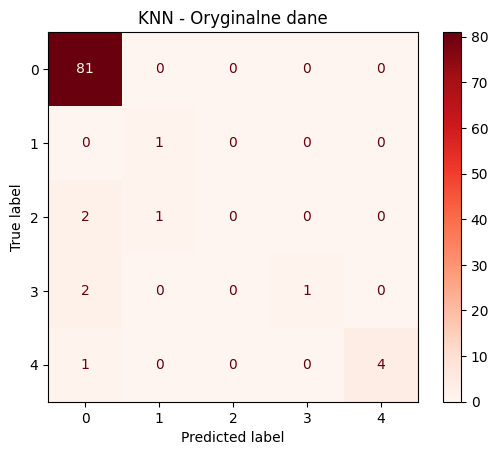

In [40]:
cm = results_knn["KNN"]["Oryginalny"]["Confusion_Matrix_Val"]

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots()
disp.plot(cmap="Reds", ax=ax)
ax.grid(False)
plt.title("KNN - Oryginalne dane")
plt.show()

Klasa 0 (najliczniejsza):

- 81 próbek poprawnie sklasyfikowanych .

- Żadna próbka klasy 0 nie została pomylona — bardzo dobra skuteczność.

Klasa 1:

- 1 przypadek poprawnie sklasyfikowany.

- Brak błędnych klasyfikacji – ale niska liczebność może zaniżać wartość statystyczną tej oceny.

Klasa 2:

- 1 przypadek poprawnie sklasyfikowany.

- 2 przypadki błędnie zaklasyfikowane jako klasa 0 oraz 1 przypadek jako klasa 1.

Klasa 3:

- 1 przypadek poprawny.

- 2 błędnie przypisane do klasy 0.

Klasa 4:

- 4 poprawne klasyfikacje.

- 1 błędna – przypisana do klasy 0.


Model KNN bardzo dobrze radzi sobie z klasyfikacją najliczniejszej klasy 0, co wpływa na wysokie metryki ogólne (accuracy, recall, F1-score). Gorzej radzi sobie z mniejszościowymi klasami – często błędnie przypisuje je do klasy 0. To zjawisko jest typowe dla niezbalansowanych zbiorów – model „uczy się” rozpoznawać dominującą klasę, ignorując słabsze.



## Optymalizacja hiperparametrów

In [41]:
pipe = Pipeline(steps=[
    ("model", KNeighborsClassifier(
    ))
])

In [42]:
param_grid = {
    "model__n_neighbors": [5, 9, 11],
    "model__weights": ['uniform', 'distance'],
    "model__algorithm": ['auto', 'brute'],
    'model__metric': ['euclidean', 'manhattan', 'minkowski'],
    }

Siatka param_grid zawiera zestawy hiperparametrów , które zostaną przetestowane podczas tuningu.

model__n_neighbors – liczba sąsiadów branych pod uwagę w algorytmie KNN:

- Testowane wartości: 5, 9, 11

- Większa liczba sąsiadów może uogólnić model, ale zmniejszyć jego czułość na lokalne struktury danych.

model__weights – sposób ważenia głosów sąsiadów:

- 'uniform' – każdy sąsiad ma taki sam wpływ (głos),

- 'distance' – bliżsi sąsiedzi mają większy wpływ niż dalsi.

model__algorithm – algorytm wyszukiwania najbliższych sąsiadów:

- 'auto' – automatycznie wybiera najlepszy algorytm w zależności od danych,

- 'brute' – przeszukuje wszystkie punkty (wolniejsze, ale czasem dokładniejsze).

model__metric – metryka odległości:

- 'euclidean' – odległość euklidesowa (domyślna),

- 'manhattan' – odległość taksówkowa (L1),

- 'minkowski' – uogólniona metryka (z parametrem p, domyślnie p=2 czyli euklidesowa).

Ten param_grid służy do przeszukiwania siatki parametrów w celu znalezienia najbardziej optymalnych ustawień dla modelu KNN w danym zadaniu klasyfikacyjnym.

In [43]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=19)

f1_custom = make_scorer(f1_score, average="weighted", zero_division=0)

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_grid,
    n_iter=36,           
    scoring=f1_custom,   
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=19
)

Ten fragment kodu pozwala na efektywną optymalizację hiperparametrów modelu z użyciem walidacji krzyżowej, losowego przeszukiwania i ważonego F1-score jako miary jakości. Dzięki temu możemy dobrać konfigurację modelu, która najlepiej radzi sobie z klasyfikacją (szczególnie w przypadku niezrównoważonych klas).

In [44]:
search.fit(X_train, y_train)

print("Najlepsze parametry:", search.best_params_)
print("Wynik CV (F1):", search.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Najlepsze parametry: {'model__weights': 'distance', 'model__n_neighbors': 5, 'model__metric': 'euclidean', 'model__algorithm': 'auto'}
Wynik CV (F1): 0.8614064502624383


- weights='distance' – sąsiedzi bliżsi mają większy wpływ na decyzję klasyfikatora, co zwykle poprawia jakość predykcji.

- n_neighbors=5 – optymalna liczba sąsiadów to 5.

- metric='euclidean' – najlepszą metryką okazała się standardowa odległość euklidesowa.

- algorithm='auto' – model sam wybiera najlepszy algorytm wyszukiwania sąsiadów w zależności od danych.

Średnia wartość ważonego F1-score w 5-krotnej walidacji wyniosła ~0.861, co wskazuje na dobrą ogólną jakość modelu przy jednoczesnym uwzględnieniu zarówno precyzji, jak i czułości (szczególnie ważne w niezbalansowanych zbiorach).

In [45]:
best_model = search.best_estimator_

In [46]:
model = best_model
model_name = "KNN_tuned"
results = train_and_evaluate_model(model, model_name, X_train, y_train, X_val, y_val)

In [47]:
metrics_dict = results[0]
metrics_only = metrics_dict["KNN_tuned"].copy()
metrics_only.pop("Confusion_Matrix_Val", None)
df_results = pd.DataFrame([metrics_only], index=["KNN_tuned"])
df_results.style.apply(
    lambda row: ['background-color: #1f77d8; font-weight: bold'] * len(row),
    axis=1
).format(precision=3).hide(axis="index")

F1-Score_Train,Recall_Train,Precision_Train,Accuracy_Train,F1-Score_Val,Recall_Val,Precision_Val,Accuracy_Val
1.000,1.000,1.000,1.000,0.916,0.935,0.912,0.935


Tuning modelu zwiększył jego dopasowanie do danych treningowych, aż do perfekcji. Jednak na zbiorze walidacyjnym wyniki się nie poprawiły, co sugeruje, że model zaczął się przeuczać (overfitting). Model po tuningu jest więc bardziej skomplikowany i dokładny na danych treningowych, ale nie generalizuje lepiej na nowych danych. Przed tuningiem model był bardziej „wyważony” — trochę gorsze wyniki na treningu, ale takie same na walidacji. Uzyskane rezultaty nie potwierdzają skuteczności procesu tuningu dlatego do ewaluacji na zbiorze testowym zostanie użyty oryginalny model sprzed tuningu. 

## Ewaluacja najlepszego modelu na zbiorze testowym

In [48]:
model = knn
model_name = "KNN"
results = train_and_evaluate_model(model, model_name, X_train, y_train, X_test, y_test)

In [49]:
metrics_dict = results[0]
metrics_only = metrics_dict["KNN"].copy()
metrics_only.pop("Confusion_Matrix_Val", None)
metrics_only_renamed = {
    key.replace('_Val', '_Test'): value
    for key, value in metrics_only.items()
}
df_results = pd.DataFrame([metrics_only_renamed], index=["KNN"])
df_results.style.apply(
    lambda row: ['background-color: #1f77d8; font-weight: bold'] * len(row),
    axis=1
).format(precision=3).hide(axis="index")

F1-Score_Train,Recall_Train,Precision_Train,Accuracy_Train,F1-Score_Test,Recall_Test,Precision_Test,Accuracy_Test
0.895,0.909,0.885,0.909,0.892,0.902,0.894,0.902


Wyniki na zbiorze testowym są bardzo zbliżone do tych na treningu, co świadczy o tym, że model generalizuje całkiem dobrze — różnice między tymi zbiorami są minimalne, więc model nie przeucza się zbytnio. F1-Score i Accuracy utrzymują się na solidnym poziomie około 0.89–0.90. Dodatkowo, podobne wartości Precision i Recall na zbiorze testowym i treningowym pokazują, że model jest spójny zarówno pod kątem wykrywania pozytywnych przypadków (Recall), jak i poprawności predykcji pozytywnych (Precision).

## Macierz pomyłek – zbiór testowy

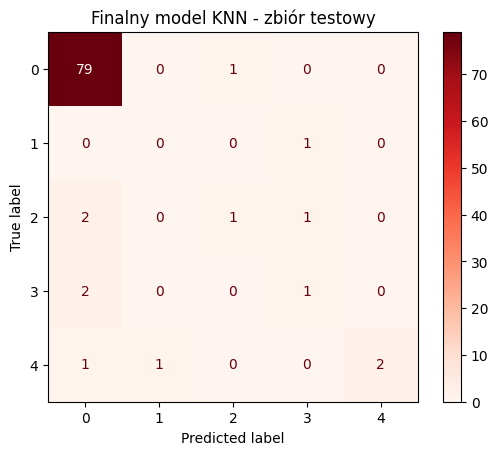

In [ ]:
cm = results[0]["KNN"]["Confusion_Matrix_Val"]

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots()
disp.plot(cmap="Reds", ax=ax)
ax.grid(False)
plt.title("Finalny model KNN - zbiór testowy")
plt.show()

- Klasa 0 jest bardzo dobrze rozpoznawana — 79 przykładów zostało poprawnie zaklasyfikowanych, tylko 1 został pomylony z klasą 2.

- Klasa 1 została sklasyfikowana błędnie — jedyny przykład tej klasy zostały zaklasyfikowane jako klasa 3.

- Klasa 2 jest rozproszona: 2 przykłady zostały błędnie sklasyfikowane jako 0, tylko 1 poprawnie, 1 przykład jako klasa 3.

- Klasa 3 także słabo rozpoznawana — 2 przykłady pomylone jako 0, 1 poprawnie jako 3.

- Klasa 4 jest rozproszona: 1 przykład pomylony jako 0, 1 jako 1, 2 poprawnie jako 4.

Model świetnie radzi sobie z klasą 0 (duża liczba poprawnych klasyfikacji, mało błędów). Największe problemy są z klasą 1, która w ogóle nie została poprawnie rozpoznana — jedyny przykład należący do tej klasy został sklasyfikowany jako klasa 3. Klasy 2, 3 i 4 są klasyfikowane mniej dokładnie, model często myli je ze sobą lub z klasą 0. Może to oznaczać, że model ma problem z rozróżnianiem klas podobnych lub o mniejszej liczbie próbek.

## Podsumowanie i wnioski

Celem projektu była budowa modelu predykcyjnego, który na podstawie danych demograficznych oraz wyników badań laboratoryjnych będzie klasyfikował stan zdrowia pacjentów w kontekście chorób wątroby. Kluczowym zadaniem jest przypisanie pacjenta do jednej z pięciu klas. Przeprowadzono imputację braków danych, oraz balansowanie klas. Dokonano wyboru cech, które najlepiej różnicują klasy chorób. Wytrenowano wiele modeli przy kilku rodzajach oversamplingu i wybrano najlepszy z nich do tuningu hiperparametrów, który nie przyniósł jednak poprawy metryk. Z tego powodu naszym najlepszym modelem okazał się model k-Nearest Neighbours trenowany na oryginalnych, niezbalansowanych danych. Wyniki metryk uzyskanych po jego wytrenowaniu pozwalają myśleć o wdrożeniu go w prawdziwych problemach, lecz należy jego klasyfikację brać z pewną dozą ostrożności.